In [5]:
from ast import increment_lineno
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [6]:
print(house_df.shape)
print(house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))


(1168, 81)
object     43
int64      35
float64     3
Name: count, dtype: int64

Null칼럼과 그 건수:
 PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtExposure      24
BsmtFinType2      24
BsmtQual          23
BsmtCond          23
BsmtFinType1      23
MasVnrArea         8
Electrical         1
dtype: int64


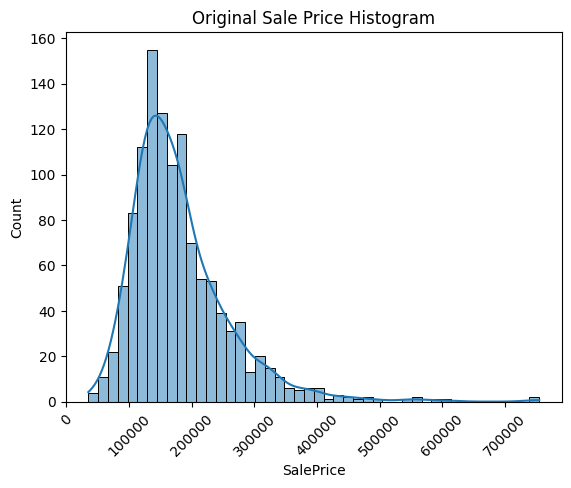

In [7]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation = 45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

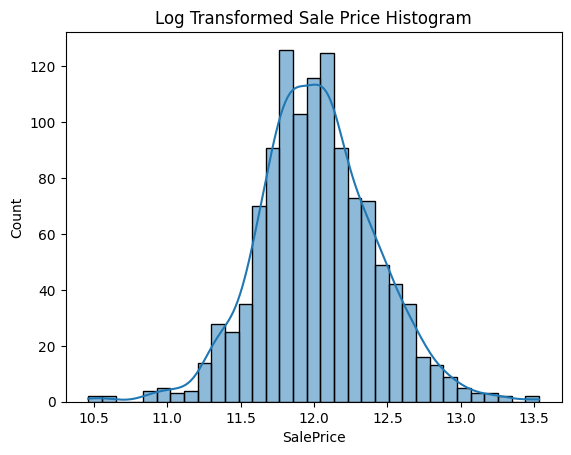

In [8]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [9]:
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True, errors='ignore')

house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('##Null Type: \n', house_df.dtypes[null_column_count.index])

##Null Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [10]:
print('get_dummies() 수행전 데이터 shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()> 0]
print('## Null Type : \n', house_df_ohe.dtypes[null_column_count.index])


get_dummies() 수행전 데이터 shape: (1168, 75)
get_dummies() 수행 후 데이터 shape: (1168, 267)
## Null Type : 
 Series([], dtype: object)


In [14]:
from sklearn.metrics import mean_squared_error

def get_rmse(model):
  pred = model.predict(x_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

In [12]:
def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error # Removed duplicate import

y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge()
ridge_reg. fit(x_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.131
Ridge 로그 변환된 RMSE: 0.132
Lasso 로그 변환된 RMSE: 0.177


[np.float64(0.13096484089028868),
 np.float64(0.1324937393212144),
 np.float64(0.17727257859957424)]

In [19]:
def get_top_bottom_coef(model, n=10):
  coef = pd.Series(model.coef_, index=x_features.columns)

  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

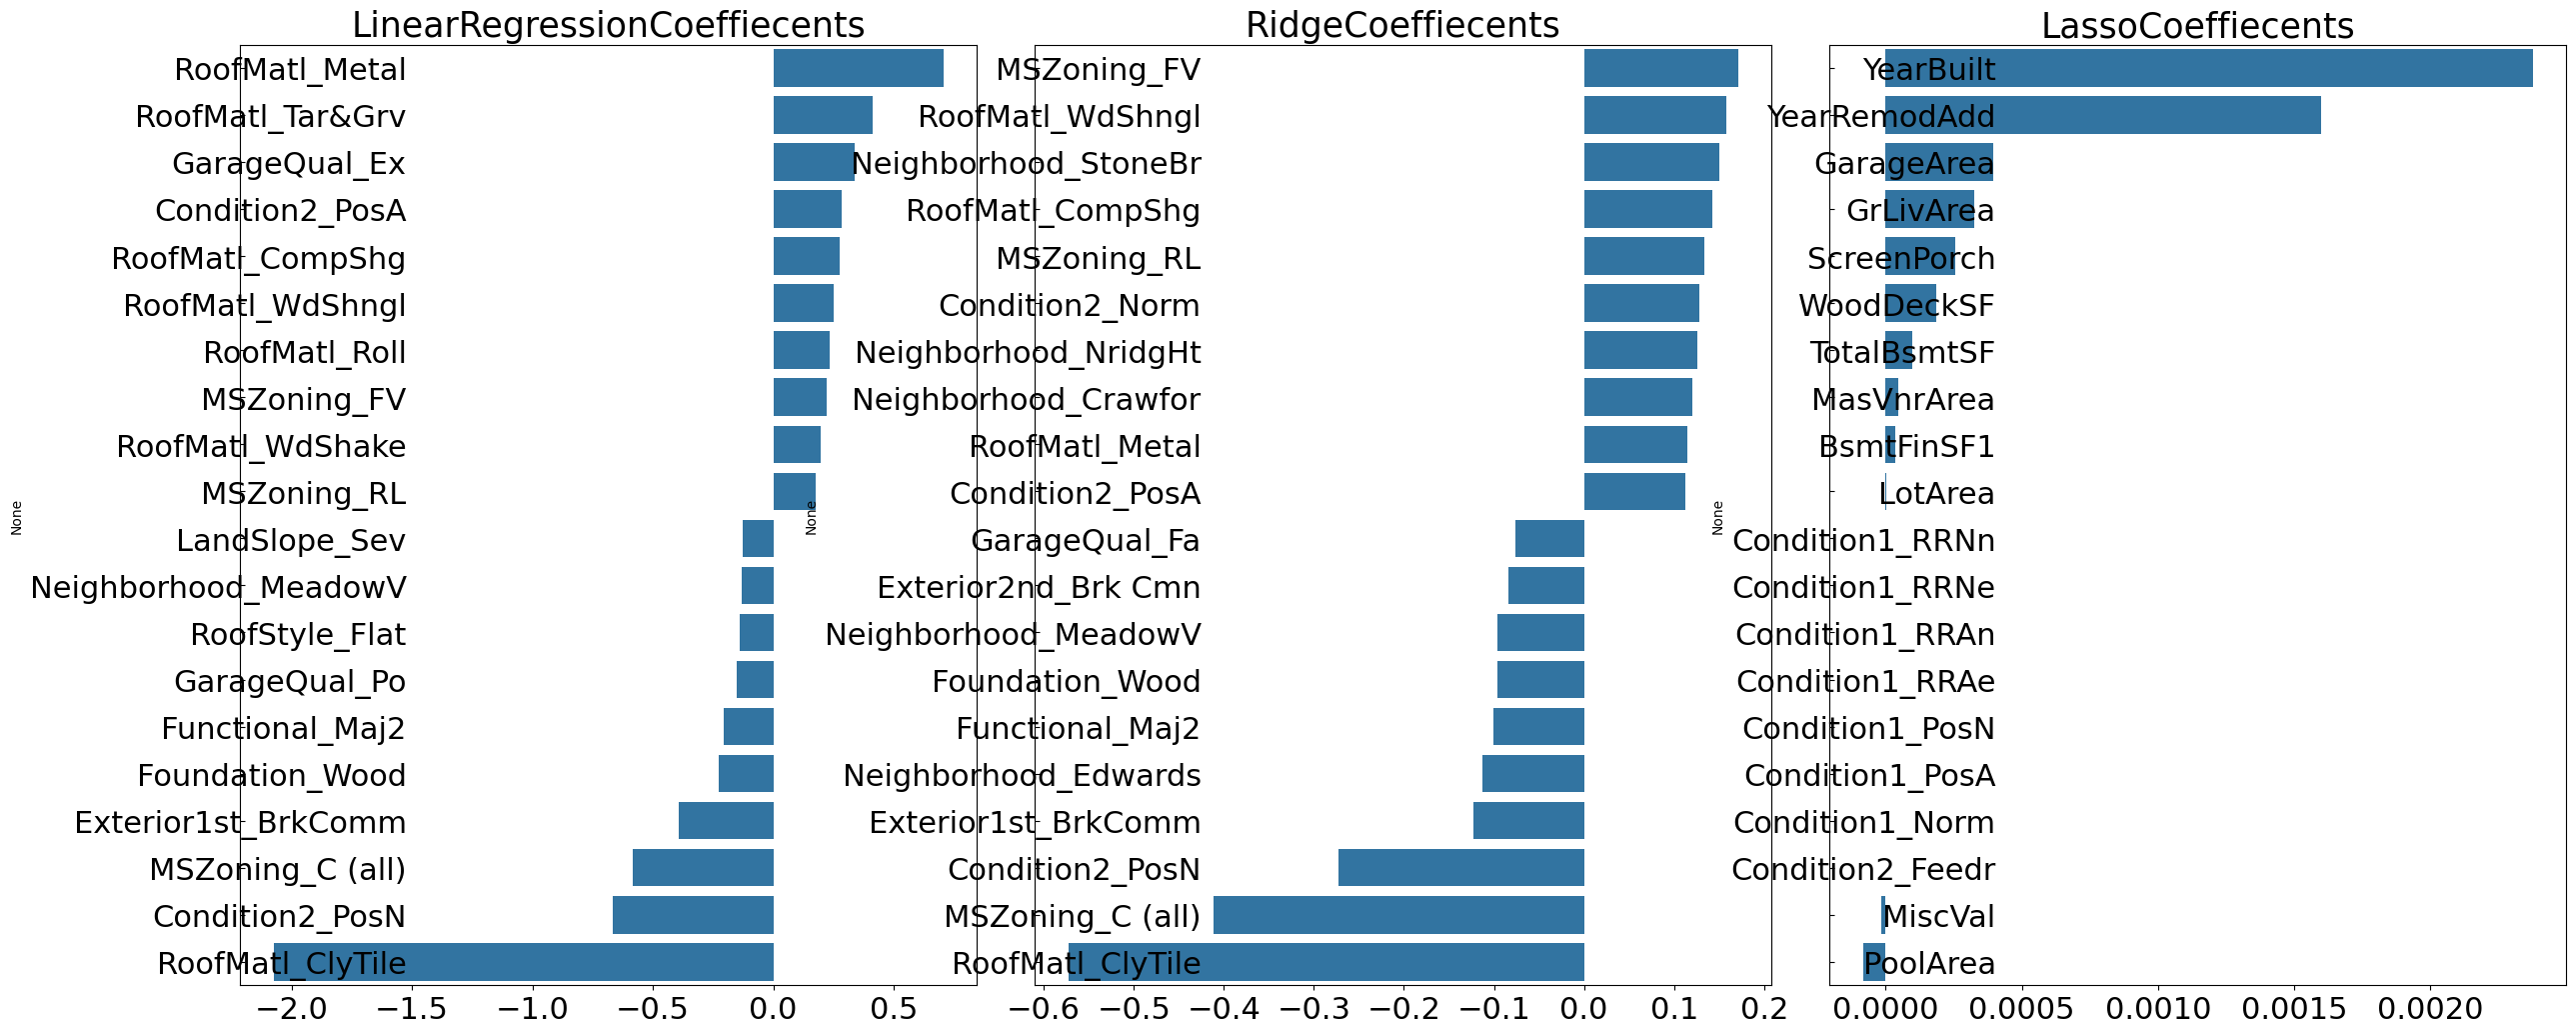

In [21]:
def visualize_coefficient(models):
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()

  for i_num, model in enumerate(models):
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])

    axs[i_num].set_title(model.__class__.__name__+ 'Coeffiecents', size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [23]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    rmse_list = np.sqrt(-cross_val_score(model, x_features, y_target, scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트:{1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값:{1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)



LinearRegression CV RMSE 값 리스트:[0.247 0.196 0.11  0.129 0.116]
LinearRegression CV 평균 RMSE 값:0.16

Ridge CV RMSE 값 리스트:[0.213 0.172 0.12  0.131 0.119]
Ridge CV 평균 RMSE 값:0.151

Lasso CV RMSE 값 리스트:[0.287 0.212 0.173 0.185 0.17 ]
Lasso CV 평균 RMSE 값:0.205


In [25]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, tick_params):
    grid_model = GridSearchCV(model, param_grid=tick_params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(x_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,np.round(rmse,4), grid_model.best_params_))

ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8,10, 12, 15, 20]}
lasso_params = { 'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1509, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.152, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.131
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.122


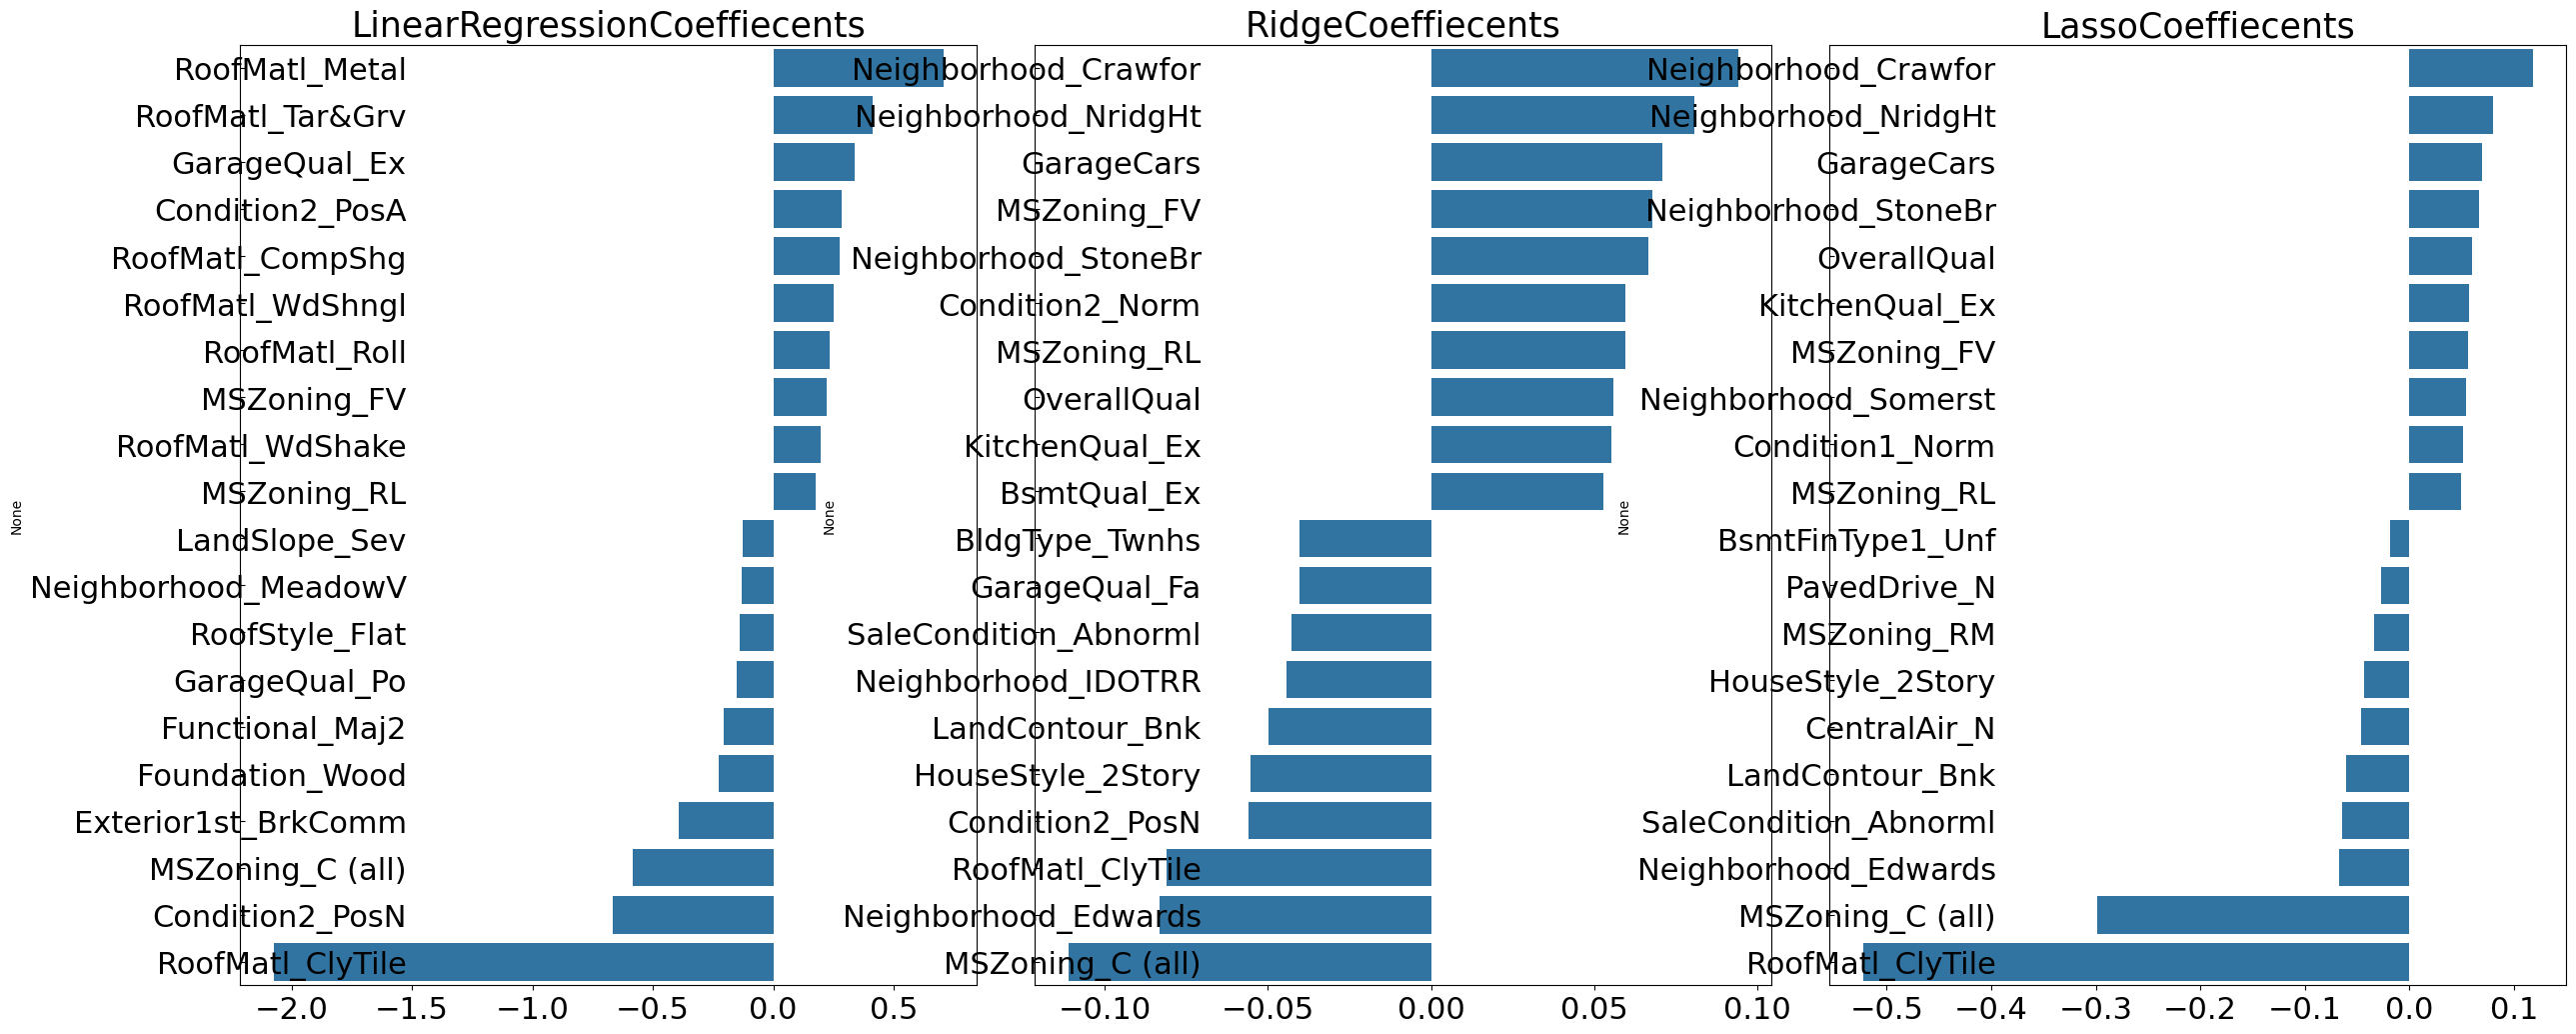

In [26]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg,lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)


In [28]:
from scipy.stats import skew

feather_index = house_df.dtypes[house_df.dtypes !='object'].index

skew_features = house_df[feather_index].apply(lambda x: skew(x))

skew_features_top = skew_features[skew_features >1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          22.099034
PoolArea         14.377604
LotArea          11.097791
3SsnPorch        11.040646
LowQualFinSF      9.608861
BsmtFinSF2        4.507199
KitchenAbvGr      4.488325
BsmtHalfBath      4.133732
ScreenPorch       3.976766
EnclosedPorch     3.093917
LotFrontage       2.760540
OpenPorchSF       2.454159
MasVnrArea        2.418589
BsmtFinSF1        1.881057
TotalBsmtSF       1.864686
WoodDeckSF        1.546567
1stFlrSF          1.488257
GrLivArea         1.474257
MSSubClass        1.391605
dtype: float64


In [29]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])


In [30]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha': [0.05, 0.1,1,5,8,10,12,15,20]}
lasso_params = { 'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1332, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1296, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.124
Ridge 로그 변환된 RMSE: 0.116
Lasso 로그 변환된 RMSE: 0.111


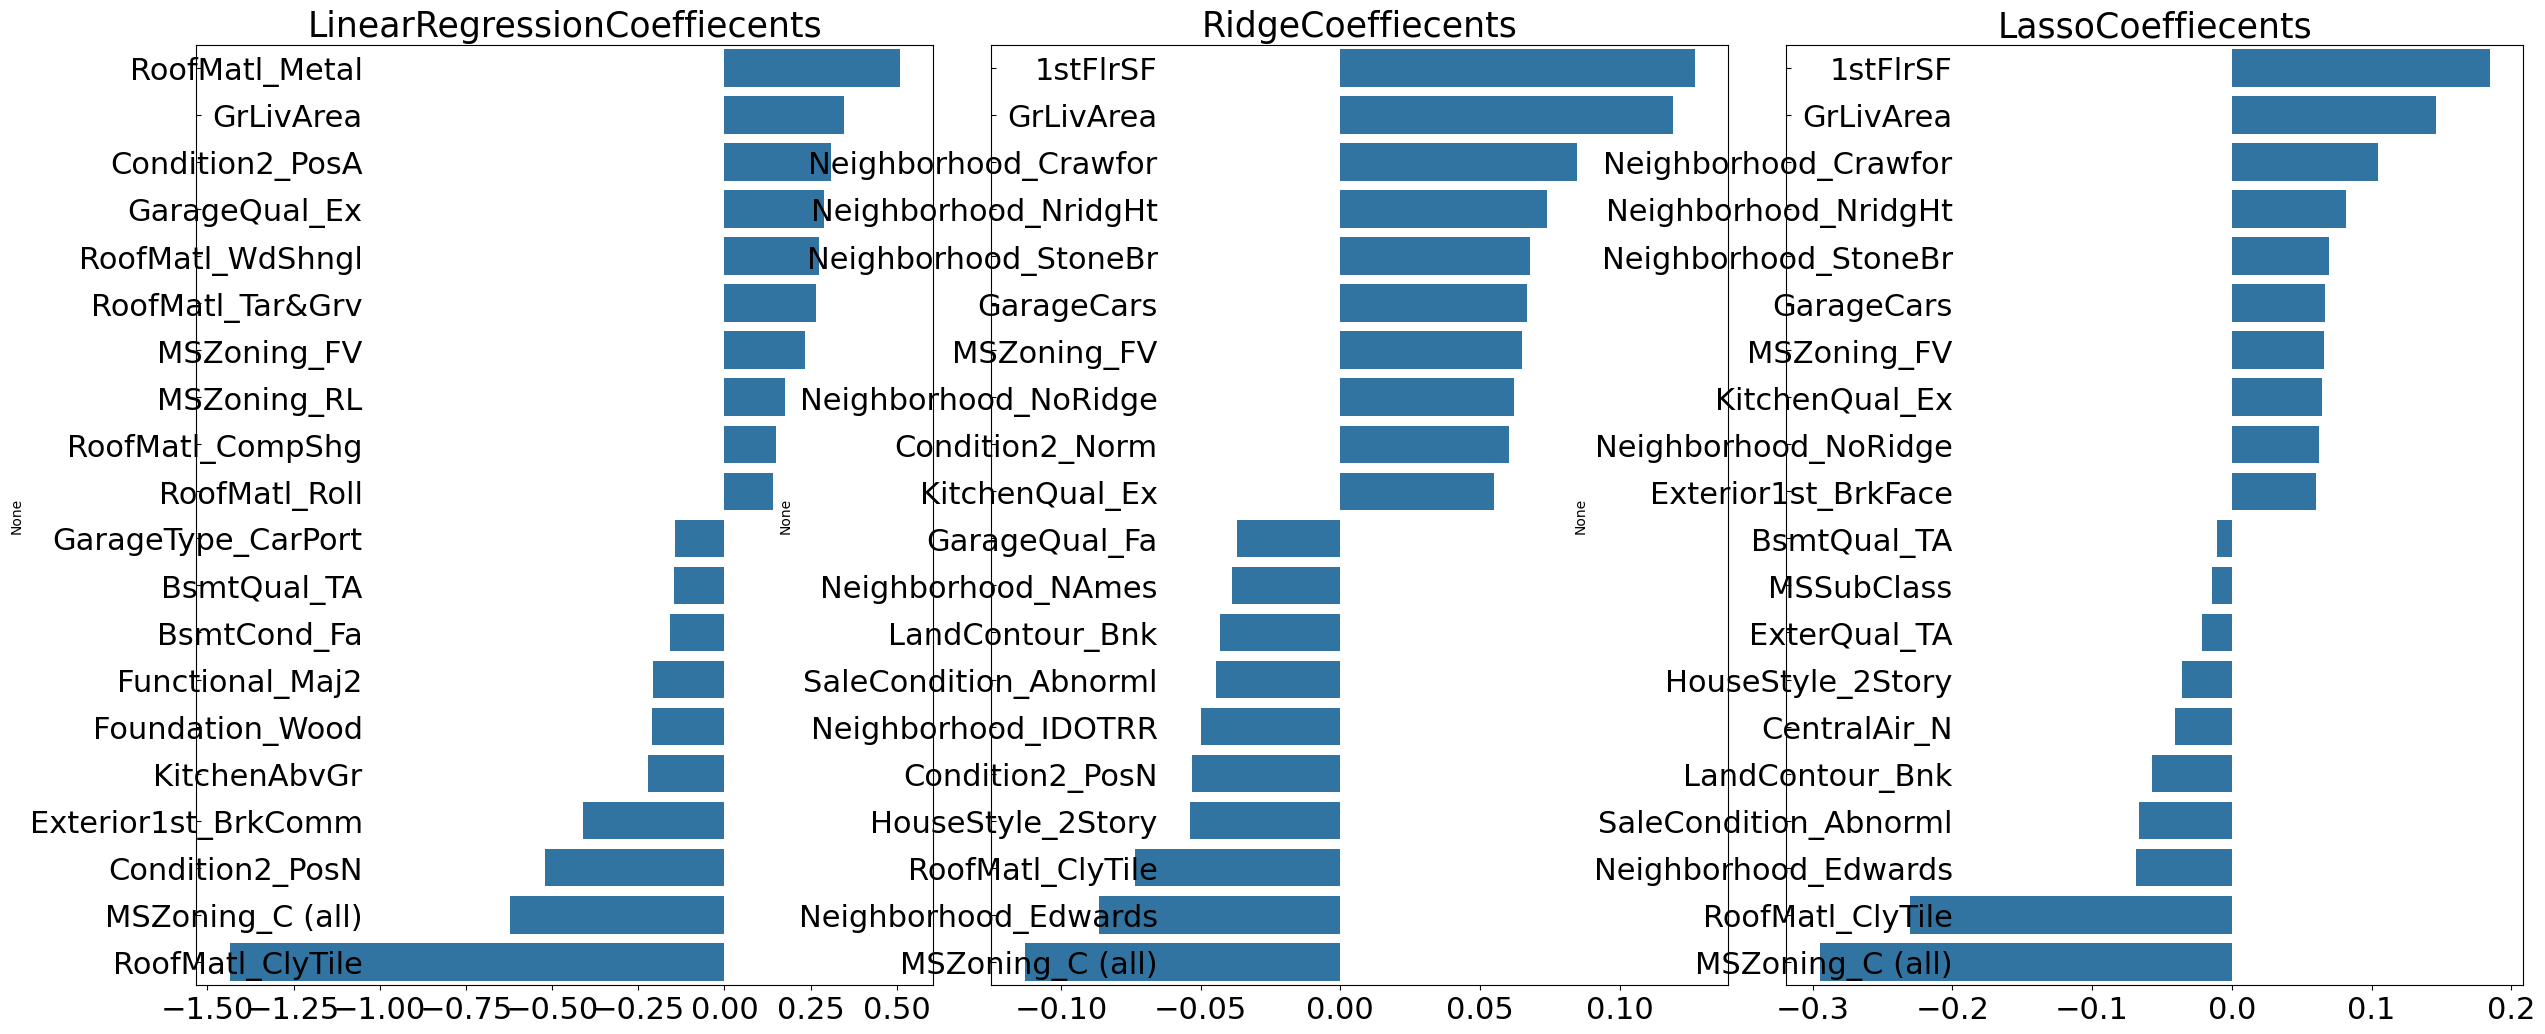

In [31]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg,lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

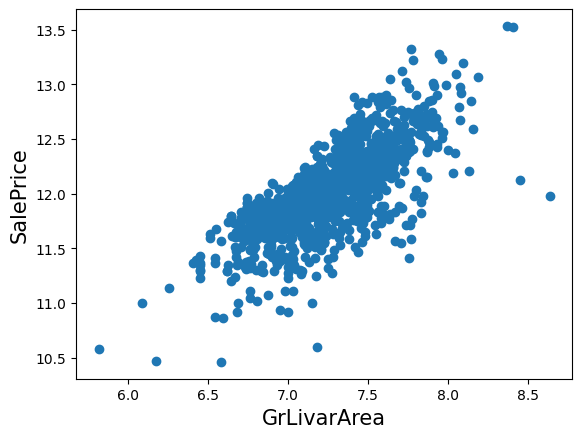

In [32]:
plt.scatter(house_df['GrLivArea'], y=house_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivarArea', fontsize=15)
plt.show()


In [36]:
# 그래프에서 확인한 GrLivArea와 SalePrice의 눈금 범위를 기준으로 이상치 정의
# GrLivArea가 6.0보다 작거나 8.5보다 큰 경우
cond1 = (house_df_ohe['GrLivArea'] < 6.0) | (house_df_ohe['GrLivArea'] > 8.5)
# SalePrice가 10.5보다 작거나 13.5보다 큰 경우
cond2 = (house_df_ohe['SalePrice'] < 10.5) | (house_df_ohe['SalePrice'] > 13.5)

# GrLivArea 또는 SalePrice가 정의된 범위를 벗어나는 데이터를 이상치로 간주
outlier_index = house_df_ohe[cond1 | cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_one shape:', house_df_ohe.shape)

house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_one shape:', house_df_ohe.shape)

이상치 레코드 index: [ 379  579  647  864 1069]
이상치 삭제 전 house_df_one shape: (1166, 267)
이상치 삭제 후 house_df_one shape: (1161, 267)


In [39]:
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha': [0.05, 0.1,1,5,8,10,12,15,20]}
lasso_params = { 'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1144, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1144, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.131
Ridge 로그 변환된 RMSE: 0.118
Lasso 로그 변환된 RMSE: 0.119


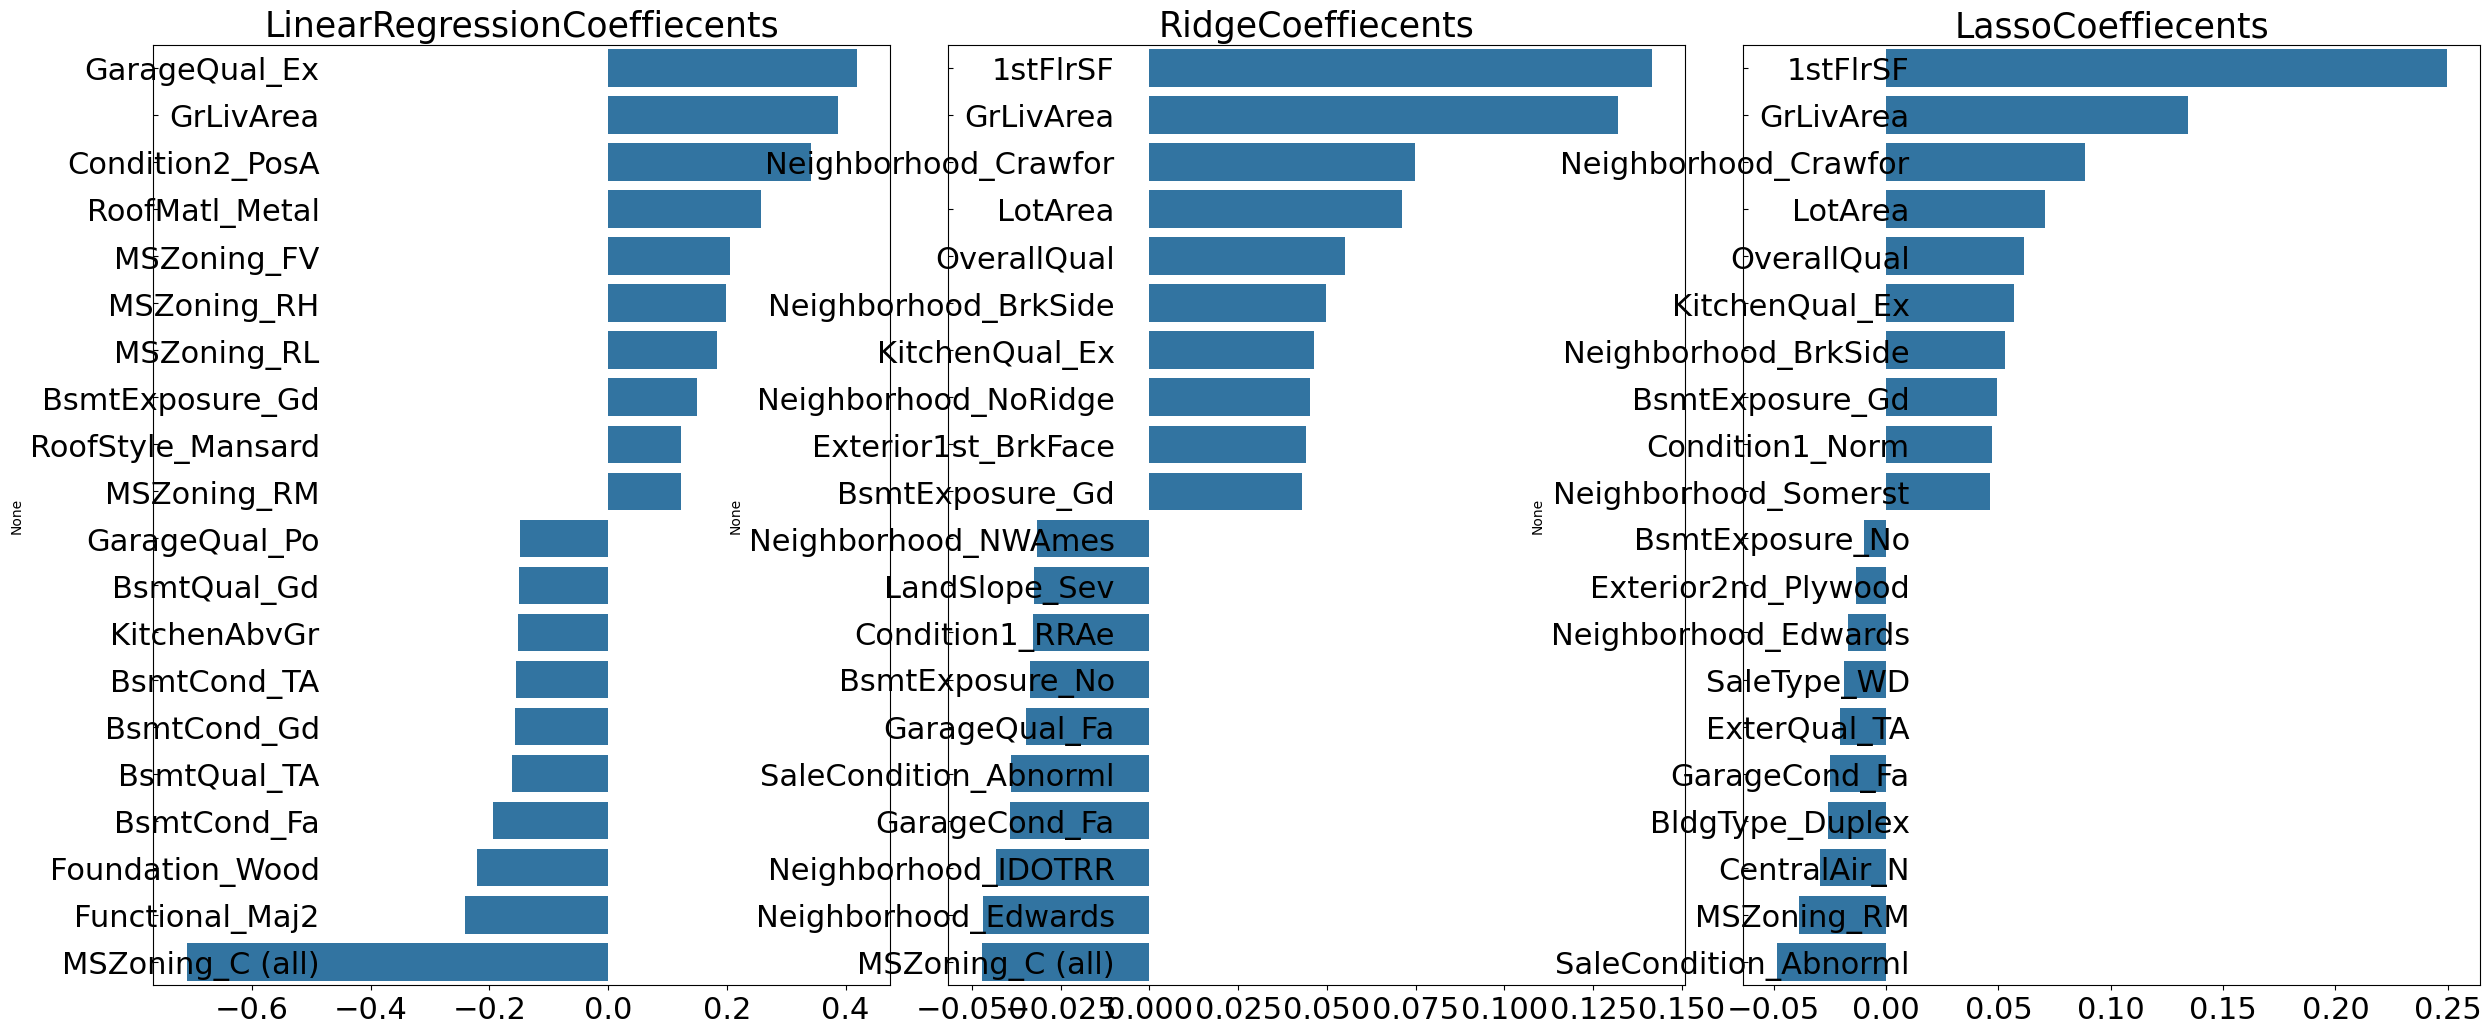

In [40]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg,lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [41]:
# 원본 데이터프레임 다시 로드 및 복사
house_df = house_df_org.copy()

# 이전 전처리 단계 다시 적용 (결측치 처리 및 SalePrice 로그 변환)
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True, errors='ignore')
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# 왜곡된 피처 로그 변환 다시 적용
feather_index = house_df.dtypes[house_df.dtypes !='object'].index
skew_features = house_df[feather_index].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features >1]
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

# One-Hot Encoding 다시 적용
house_df_ohe = pd.get_dummies(house_df)

# GrLivArea가 8.5보다 큰 경우만 이상치로 정의
cond1 = (house_df_ohe['GrLivArea'] > 8.5)

# 이상치 레코드 index 추출
outlier_index = house_df_ohe[cond1].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# 이상치 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index: [64]
이상치 삭제 전 house_df_ohe shape: (1168, 267)
이상치 삭제 후 house_df_ohe shape: (1167, 267)


In [42]:
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha': [0.05, 0.1,1,5,8,10,12,15,20]}
lasso_params = { 'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1226, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1208, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.111
Ridge 로그 변환된 RMSE: 0.098
Lasso 로그 변환된 RMSE: 0.098


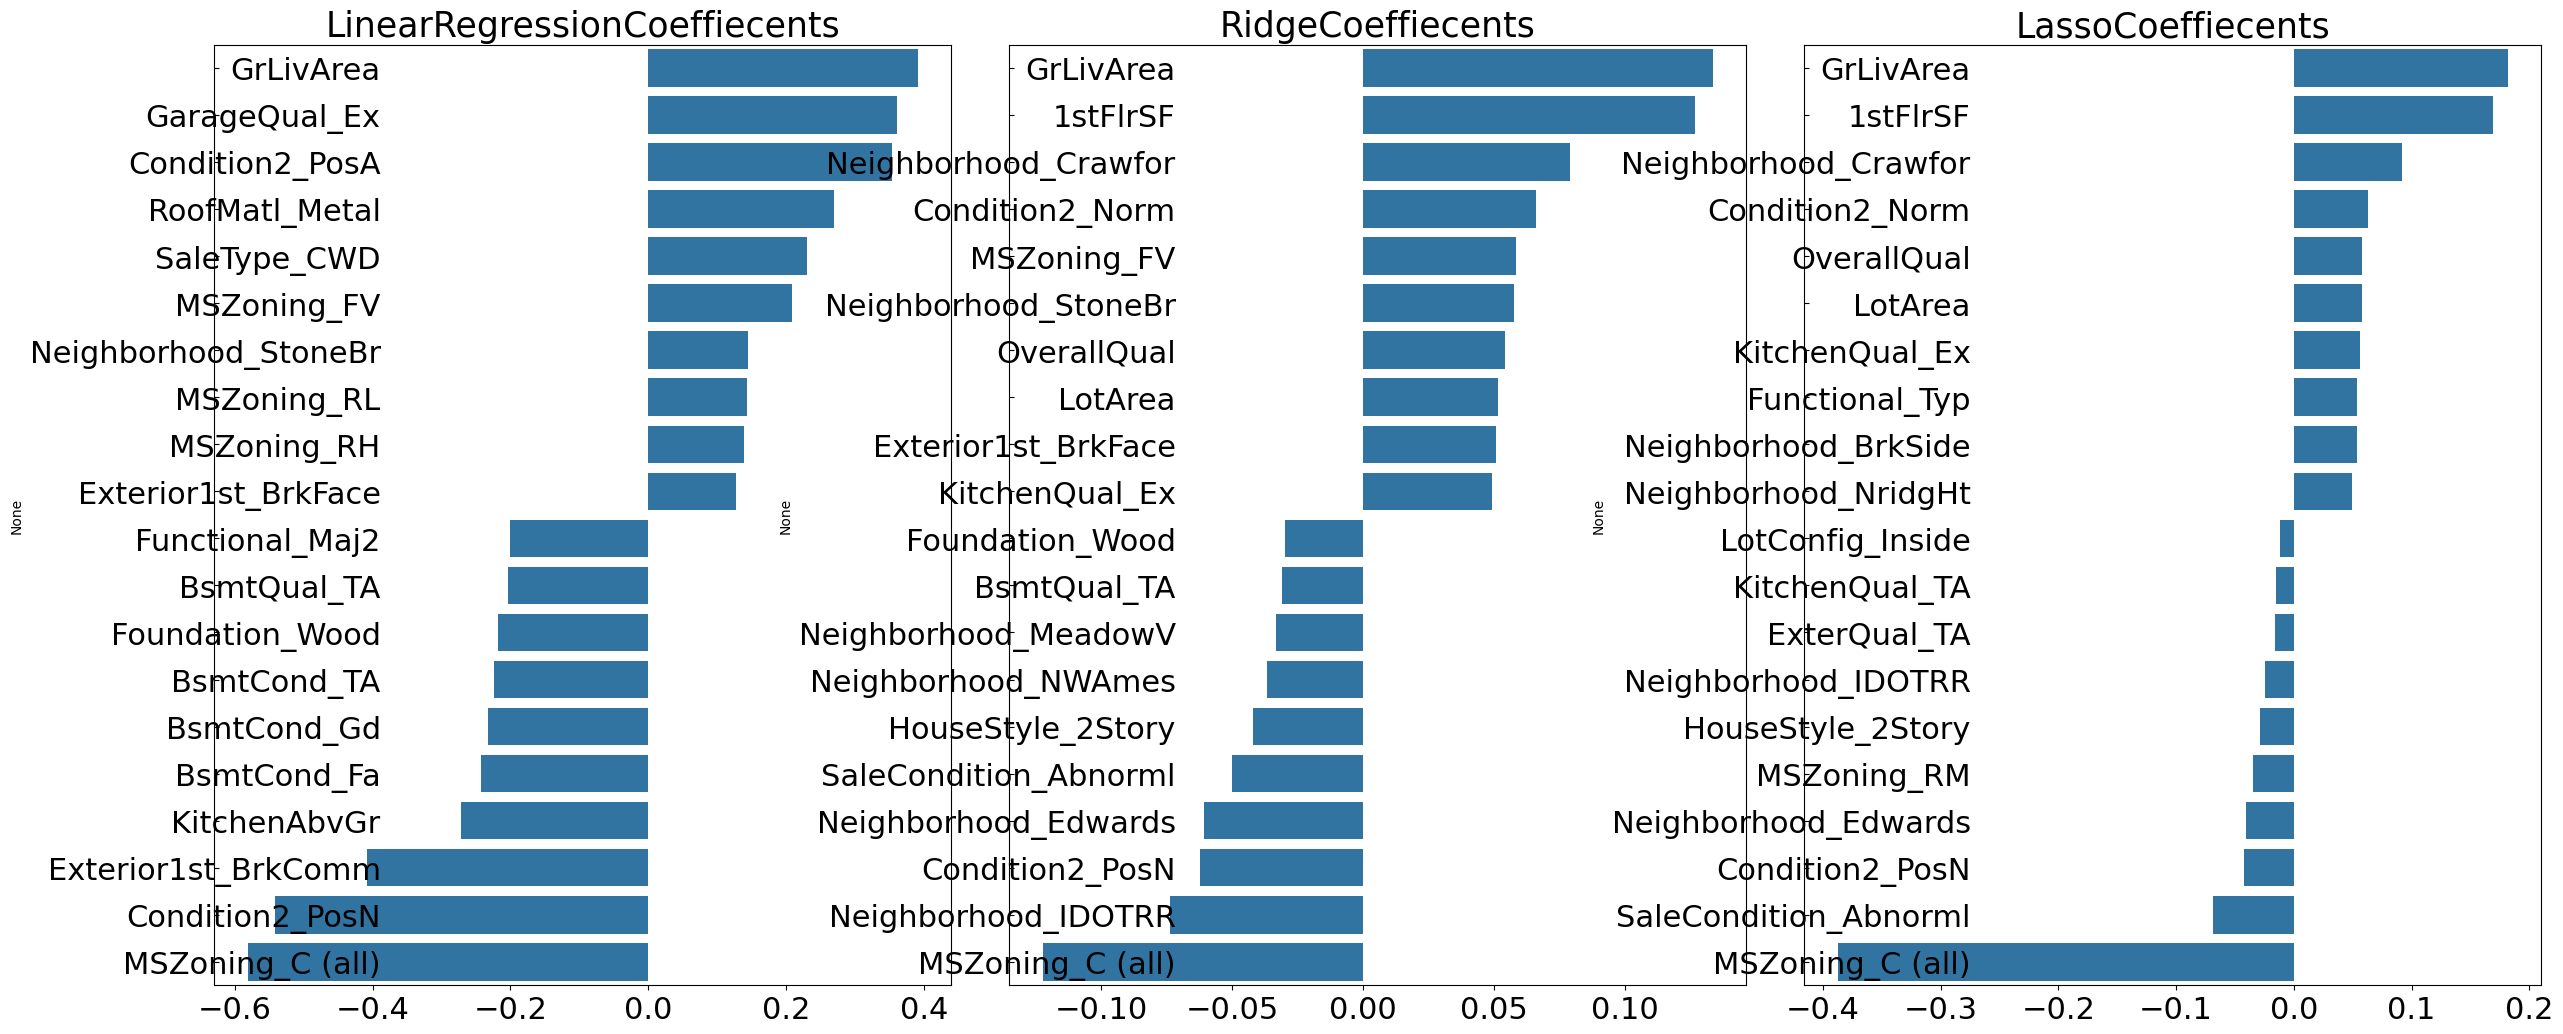

In [43]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

models = [lr_reg, ridge_reg,lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [45]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.132, 최적 alpha:{'n_estimators': 1000}


In [48]:
from math import lgamma
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2940
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 164
[LightGBM] [Info] Start training from score 12.020534
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.025656
[LightGBM] [Warning] Found w

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2922
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 154
[LightGBM] [Info] Start training from score 12.022622


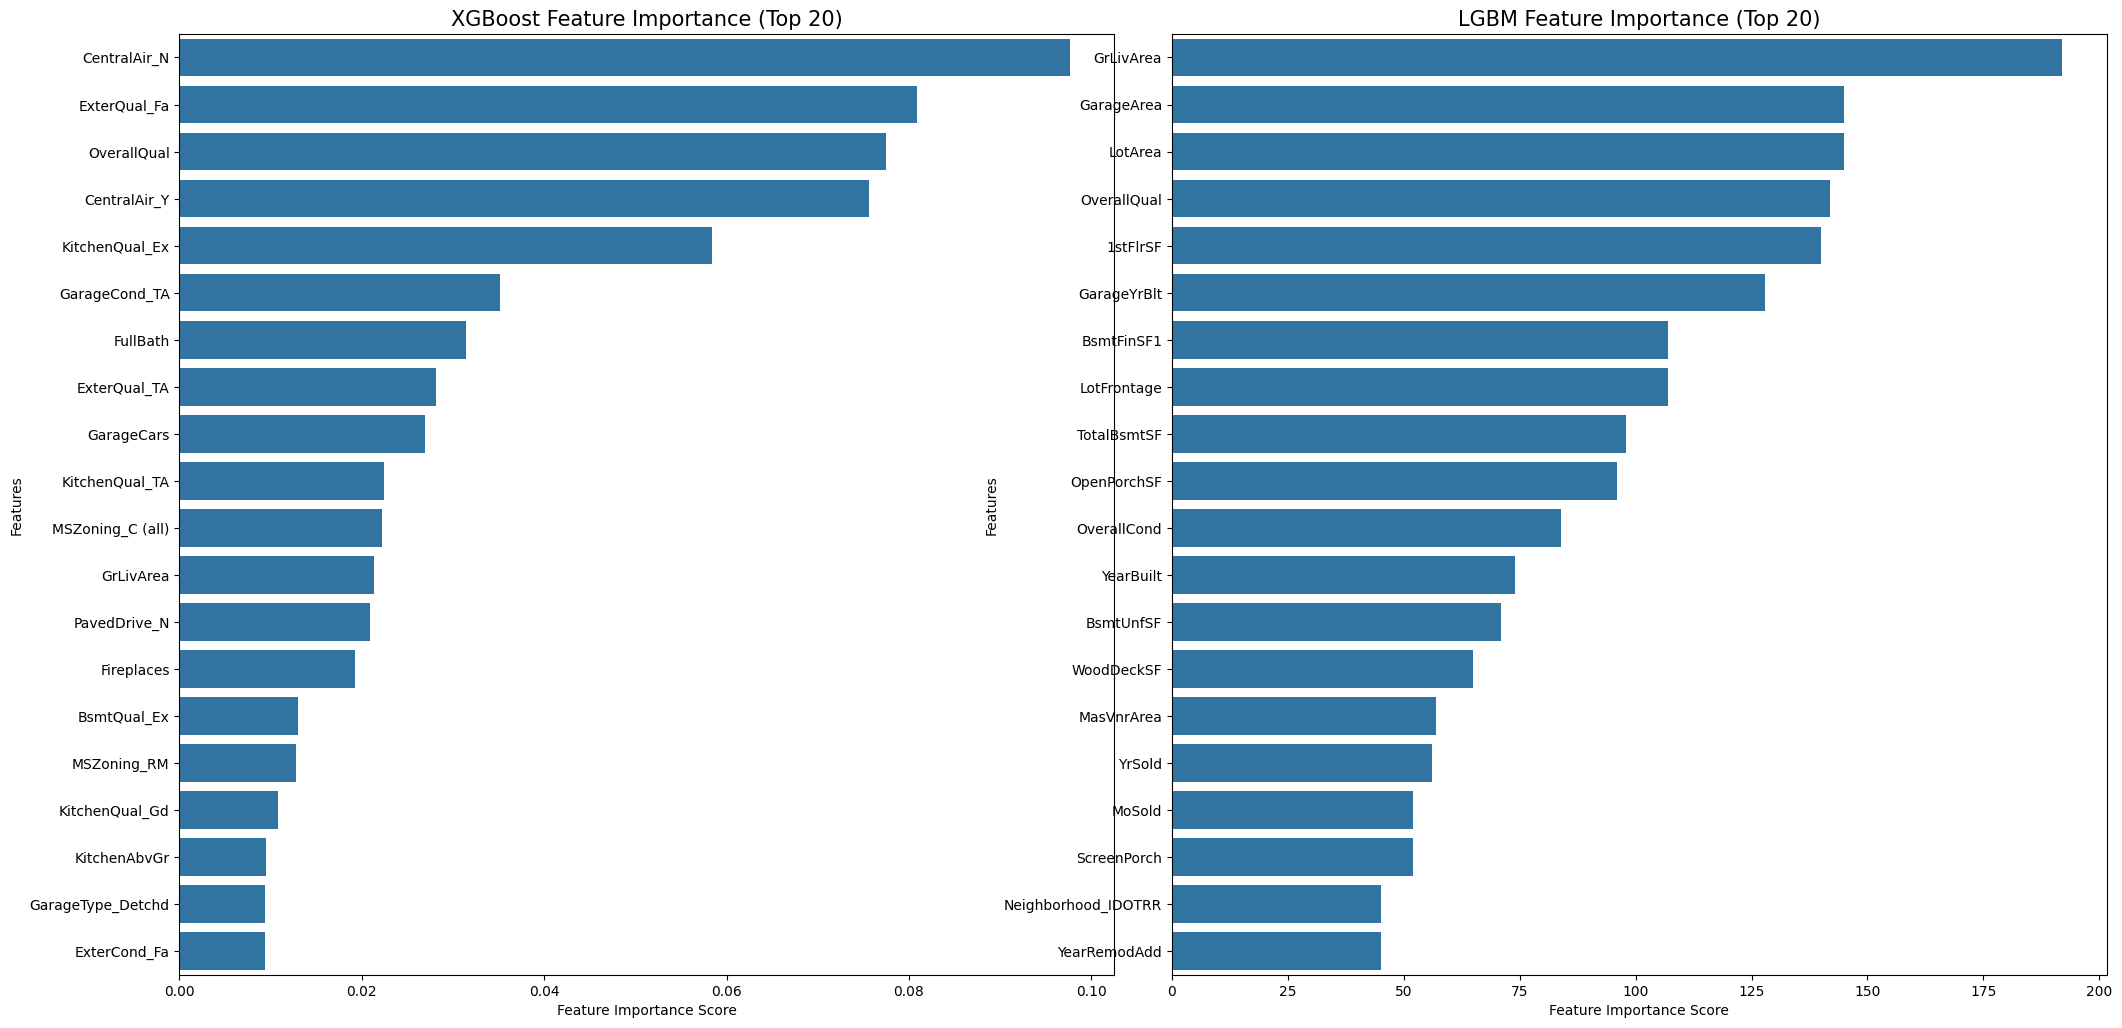

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost 모델 학습 (이미 학습되었을 수 있지만, 안전하게 다시 학습)
xgb_reg.fit(x_train, y_train)
# LightGBM 모델 학습 (이미 학습되었을 수 있지만, 안전하게 다시 학습)
lgbm_reg.fit(x_train, y_train)


# XGBoost 모델의 피처 중요도 추출
xgb_feature_importance = xgb_reg.feature_importances_
xgb_feature_importance_series = pd.Series(xgb_feature_importance, index=x_features.columns)
xgb_feature_importance_sorted = xgb_feature_importance_series.sort_values(ascending=False)

# LightGBM 모델의 피처 중요도 추출
lgbm_feature_importance = lgbm_reg.feature_importances_
lgbm_feature_importance_series = pd.Series(lgbm_feature_importance, index=x_features.columns)
lgbm_feature_importance_sorted = lgbm_feature_importance_series.sort_values(ascending=False)


# 상위 20개 피처 시각화
fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
fig.tight_layout()

# XGBoost 피처 중요도 시각화
sns.barplot(x=xgb_feature_importance_sorted.head(20).values, y=xgb_feature_importance_sorted.head(20).index, ax=axs[0])
axs[0].set_title('XGBoost Feature Importance (Top 20)', size=15)
axs[0].set_xlabel('Feature Importance Score')
axs[0].set_ylabel('Features')


# LightGBM 피처 중요도 시각화
sns.barplot(x=lgbm_feature_importance_sorted.head(20).values, y=lgbm_feature_importance_sorted.head(20).index, ax=axs[1])
axs[1].set_title('LGBM Feature Importance (Top 20)', size=15)
axs[1].set_xlabel('Feature Importance Score')
axs[1].set_ylabel('Features')

plt.show()

In [51]:
from sklearn.metrics import mean_squared_error

def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE: {1}'. format(key, rmse))

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

ridge_pred = ridge_reg.predict(x_test)
lasso_pred = lasso_reg.predict(x_test)

prd = 0.4 * ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합': prd, 'Ridge': ridge_pred, 'Lasso': lasso_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.0963825781561061
Ridge 모델의 RMSE: 0.09814205419966324
Lasso 모델의 RMSE: 0.09776901507547568


In [53]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(x_train, y_train)
lgbm_reg.fit(x_train, y_train)
xgb_pred = xgb_reg.predict(x_test)
lgbm_pred = lgbm_reg.predict(x_test)

preds = 0.5*xgb_pred + 0.5*lgbm_pred
preds = {'최종혼합': preds, 'XGBM': xgb_pred, 'LGBM': lgbm_pred}

get_rmse_pred(preds)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2922
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 154
[LightGBM] [Info] Start training from score 12.022622
최종혼합 모델의 RMSE: 0.09721947187815261
XGBM 모델의 RMSE: 0.10346040132539013
LGBM 모델의 RMSE: 0.10017362689351535


In [57]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(models, x_train_n, y_train_n, x_test_n, n_folds):

  kf = KFold(n_splits=n_folds, shuffle=False)

  train_fold_pred = np.zeros((x_train_n.shape[0], len(models)))
  test_pred = np.zeros((x_test_n.shape[0], len(models)))

  for i, model in enumerate(models):
    print(model.__class__.__name__, 'model 시작')
    train_fold_pred_i = np.zeros((x_train_n.shape[0],1))
    test_pred_i = np.zeros((x_test_n.shape[0], n_folds))


    for folder_counter, (train_index, valid_index) in enumerate(kf.split(x_train_n)):

      print('\t 폴드 세트:', folder_counter, '시작')
      x_tr = x_train_n[train_index]
      y_tr = y_train_n[train_index]
      x_te = x_train_n[valid_index]

      model.fit(x_tr, y_tr)
      train_fold_pred_i[valid_index,:] = model.predict(x_te).reshape(-1,1)
      test_pred_i[:, folder_counter] = model.predict(x_test_n)

    train_fold_pred[:,i] = train_fold_pred_i.flatten()
    test_pred[:, i] = np.mean(test_pred_i, axis=1)


  return train_fold_pred, test_pred

In [59]:
x_train_n = x_train.values
x_test_n = x_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets([ridge_reg], x_train_n, y_train_n, x_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets([lasso_reg], x_train_n, y_train_n, x_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets([xgb_reg], x_train_n, y_train_n, x_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets([lgbm_reg], x_train_n, y_train_n, x_test_n, 5)

Ridge model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
Lasso model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
XGBRegressor model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
LGBMRegressor model 시작
	 폴드 세트: 0 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 746, number of used features: 143
[LightGBM] [Info] Start training from score 12.021112
	 폴드 세트: 1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2681
[LightGBM] [Info] Num

In [64]:
from typing_extensions import final
Stack_final_x_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_x_test = np.concatenate((ridge_test, lasso_test,xgb_test, lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.005)

meta_model_lasso.fit(Stack_final_x_train, y_train)
final = meta_model_lasso.predict(Stack_final_x_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE값:', rmse)

스태킹 회귀 모델의 최종 RMSE값: 0.09363882729192355


In [65]:
import pandas as pd

# 각 모델의 최종 RMSE 결과 값을 수동으로 입력 (이전 셀들의 출력을 참조)
# 이상치 제거 및 피처 변환 후 최적 파라미터 적용 결과 기준

results = {
    'Model': ['Linear Regression', 'Ridge (alpha=12)', 'Lasso (alpha=0.001)', 'XGBoost (n_estimators=1000)', 'LightGBM (n_estimators=1000)', 'Ridge-Lasso Blended (0.4*R + 0.6*L)', 'XGB-LGBM Blended (0.5*X + 0.5*L)', 'Stacking Regression'],
    'RMSE': [
        0.111, # Linear Regression (k3xrdCBRoDwd)
        0.098, # Ridge (alpha=12) (k3xrdCBRoDwd)
        0.098, # Lasso (alpha=0.001) (k3xrdCBRoDwd)
        0.10346, # XGBoost (LteOLBGVt1jh) - using test set prediction
        0.10017, # LightGBM (LteOLBGVt1jh) - using test set prediction
        0.09638, # Ridge-Lasso Blended (ikoCqI67rkqj)
        0.09722,  # XGB-LGBM Blended (LteOLBGVt1jh)
        0.09364 # Stacking Regression (-dJ4XGmP4Us1) - using test set prediction
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE')

print("모델별 RMSE 결과:")
display(results_df)

모델별 RMSE 결과:


,Model,RMSE
7,Stacking Regression,0.09364
5,Ridge-Lasso Blended (0.4*R + 0.6*L),0.09638
6,XGB-LGBM Blended (0.5*X + 0.5*L),0.09722
1,Ridge (alpha=12),0.09800
2,Lasso (alpha=0.001),0.09800
4,LightGBM (n_estimators=1000),0.10017
3,XGBoost (n_estimators=1000),0.10346
0,Linear Regression,0.11100


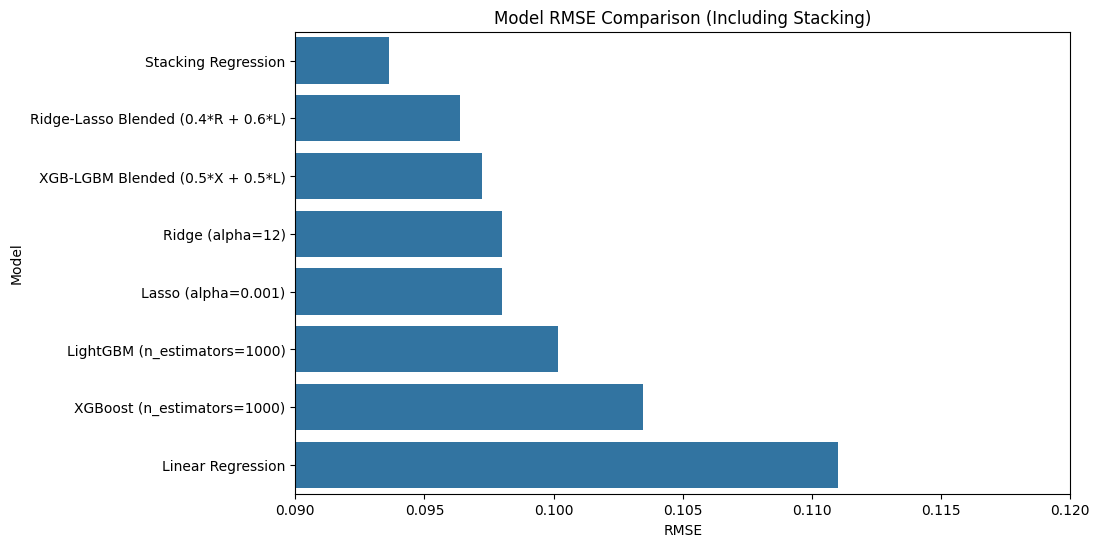

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=results_df)
plt.title('Model RMSE Comparison (Including Stacking)')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.xlim([0.09, 0.12]) # RMSE 값 범위에 따라 x축 범위 조정
plt.show()

### 1. 테스트 데이터 로드 및 전처리

In [67]:
# 테스트 데이터 로드
test_df_org = pd.read_csv('/content/test.csv')
test_df = test_df_org.copy()

# 훈련 데이터와 동일한 전처리 적용
# Id 컬럼 삭제
test_df.drop(['Id'], axis=1, inplace=True, errors='ignore')

# 결측치 처리 (훈련 데이터에서 사용한 평균값으로 대체)
test_df.fillna(house_df.mean(numeric_only=True), inplace=True) # 훈련 데이터의 평균 사용

# 왜곡된 피처 로그 변환 (훈련 데이터에서 확인된 왜곡된 피처에 대해 적용)
# 'SalePrice'는 테스트 데이터에 없으므로 제외
test_feather_index = test_df.dtypes[test_df.dtypes !='object'].index
test_skew_features = test_df[test_feather_index].apply(lambda x: skew(x)) # 테스트 데이터의 왜곡도 계산
# 훈련 데이터에서 왜곡도가 1보다 컸던 피처들에 대해 테스트 데이터에도 로그 변환 적용
# 훈련 데이터의 skew_features_top.index 사용
test_df[skew_features_top.index] = np.log1p(test_df[skew_features_top.index])


# One-Hot Encoding 적용 (훈련 데이터에 맞춰 컬럼 생성)
test_df_ohe = pd.get_dummies(test_df)

# 훈련 데이터와 테스트 데이터의 컬럼 일치시키기
# 훈련 데이터에만 있고 테스트 데이터에는 없는 컬럼 추가 (값은 0)
train_cols = x_features.columns
test_cols = test_df_ohe.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    test_df_ohe[c] = 0

# 테스트 데이터에만 있고 훈련 데이터에는 없는 컬럼 삭제
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    test_df_ohe.drop(c, axis=1, inplace=True)

# 훈련 데이터 컬럼 순서와 일치시키기
test_df_ohe = test_df_ohe[train_cols]

print("테스트 데이터 전처리 후 shape:", test_df_ohe.shape)

테스트 데이터 전처리 후 shape: (292, 266)


### 2. 베이스 모델 예측

In [68]:
# 학습된 베이스 모델들 (Ridge, Lasso, XGBoost, LightGBM)을 사용하여 테스트 데이터 예측

# Ridge 모델 예측 (훈련 시 사용한 alpha 값 사용)
ridge_reg_test_pred = ridge_reg.predict(test_df_ohe.values) # .values 추가하여 numpy 배열로 변환

# Lasso 모델 예측 (훈련 시 사용한 alpha 값 사용)
lasso_reg_test_pred = lasso_reg.predict(test_df_ohe.values) # .values 추가하여 numpy 배열로 변환

# XGBoost 모델 예측
xgb_reg_test_pred = xgb_reg.predict(test_df_ohe.values) # .values 추가하여 numpy 배열로 변환

# LightGBM 모델 예측
lgbm_reg_test_pred = lgbm_reg.predict(test_df_ohe.values) # .values 추가하여 numpy 배열로 변환

print("베이스 모델 예측 완료")

베이스 모델 예측 완료


### 3. 스태킹 메타 모델 예측

In [69]:
# 베이스 모델 예측 결과를 스태킹 메타 모델의 입력으로 사용

# 베이스 모델 예측 결과를 numpy 배열로 결합 (Stack_final_x_test와 동일한 형태)
Stack_base_test_pred = np.concatenate((ridge_reg_test_pred.reshape(-1, 1),
                                      lasso_reg_test_pred.reshape(-1, 1),
                                      xgb_reg_test_pred.reshape(-1, 1),
                                      lgbm_reg_test_pred.reshape(-1, 1)), axis=1)


# 학습된 메타 모델(Lasso)로 최종 예측 수행
final_test_pred = meta_model_lasso.predict(Stack_base_test_pred)

print("스태킹 메타 모델 예측 완료")

스태킹 메타 모델 예측 완료


### 4. 예측 결과 역변환 및 제출 파일 생성

In [70]:
# 예측 값 역변환 (log1p의 역변환은 expm1)
final_test_pred_original_scale = np.expm1(final_test_pred)

# 제출 파일 생성
submission_df = pd.DataFrame({'Id': test_df_org['Id'], 'SalePrice': final_test_pred_original_scale})

# CSV 파일로 저장 (index=False)
submission_df.to_csv('submission_stacking.csv', index=False)

print("캐글 제출 파일 'submission_stacking.csv' 생성 완료")

캐글 제출 파일 'submission_stacking.csv' 생성 완료
